In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import torchvision
import os
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

from Deep_Learning.Diffusion.StanfordCars.model import DiffusionUNet
from Deep_Learning.Diffusion.StanfordCars.dataset import CarvanaDataset
from Deep_Learning.Diffusion.StanfordCars.train import train
from Deep_Learning.Diffusion.StanfordCars.functional import linear_beta_schedule, forward_diffusion_sample
from Deep_Learning.Diffusion.StanfordCars.utils import (
    load_checkpoint,
    save_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
)

In [2]:
# Values for closed form
T = 300
BETA_0 = 0.0001
BETA_T = 0.02
BETAS = linear_beta_schedule(T, BETA_0, BETA_T)

ALPHAS = 1.0 - BETAS
ALPHAS_CUMPROD = torch.cumprod(ALPHAS, dim=0)
ALPHAS_CUMPROD_PREV = F.pad(ALPHAS_CUMPROD[:-1], (1, 0), value=1.0)
SQRT_RECIP_ALPHAS = torch.sqrt(1.0 / ALPHAS)
SQRT_ALPHAS_CUMPROD = torch.sqrt(ALPHAS_CUMPROD)
SQRT_ONE_MINUS_ALPHAS_CUMPROD = torch.sqrt(1.0 - ALPHAS_CUMPROD)
POSTERIOR_VARIANCE = BETAS * (1.0 - ALPHAS_CUMPROD_PREV) / (1.0 - ALPHAS_CUMPROD)

In [3]:
# Hyperparameters etc.
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 128
NUM_EPOCHS = 10
IMG_SIZE = 128
LOAD_MODEL = False
VAL_RATIO = 0.01
IMG_TRAIN_DIR = "../Datasets/stanford_cars/train/"
IMG_TEST_DIR = "../Datasets/stanford_cars/test/"

In [4]:
def to0_1(img):
    return (img * 2) - 1.0

TRANSFORM = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1] 
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
])

R_TRANSFORM = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

class StanfordCars(torch.utils.data.Dataset):
    def __init__(self, root_path, transform = None):
        self.images = [os.path.join(root_path, file) for file in os.listdir(root_path)]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_file = self.images[index]
        image = Image.open(image_file).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image

def load_transformed_dataset():
    train = StanfordCars(IMG_TRAIN_DIR, transform=TRANSFORM)
    test = StanfordCars(IMG_TEST_DIR, transform=TRANSFORM)
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    if len(image.shape) == 4:
        image = image[0]
    plt.imshow(R_TRANSFORM(image))

data = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

C:\Users\joeag\AppData\Local\Temp\ipykernel_26240\3839190878.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize)+1)


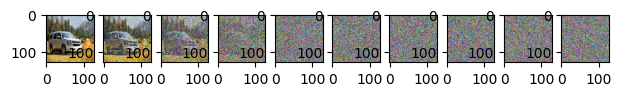

In [5]:
image = next(iter(dataloader))

plt.figure(figsize=(8, 8))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize)+1)
    image, noise = forward_diffusion_sample(image, t, SQRT_ALPHAS_CUMPROD, SQRT_ONE_MINUS_ALPHAS_CUMPROD)
    show_tensor_image(image)

In [6]:
model = DiffusionUNet(
    in_channels=3, 
    out_channels=3, 
    features=[64, 128, 256, 512], 
    time_emb_dim=32,
    betas=BETAS,
    sqrt_alphas_cumprod=SQRT_ALPHAS_CUMPROD,
    sqrt_one_minus_alphas_cumprod=SQRT_ONE_MINUS_ALPHAS_CUMPROD,
    sqrt_recip_alphas=SQRT_RECIP_ALPHAS,
    posterior_variance=POSTERIOR_VARIANCE,
    T=T,
).to(DEVICE)

optimiser = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# with torch.no_grad():
#     t = torch.randint(0, T, (BATCH_SIZE,), device=DEVICE).long()
#     x = torch.randn((BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)).to(DEVICE)
#     print(f"output.shape: {model(x, t).shape}")
#     samples = model.sample_images(device=DEVICE)
#     plt.figure(figsize=(4,4))
#     plt.axis('off')
#     for img in samples:
#         show_tensor_image(img.detach().cpu())
#     plt.show()


In [7]:
train(
    model,
    NUM_EPOCHS,
    dataloader,
    optimiser,
    loss_fn='l1',
    save_model=False,
    device=DEVICE,
)

Epoch [9/10]: 100%|██████████| 127/127 [00:56<00:00,  2.25it/s, loss=0.926]


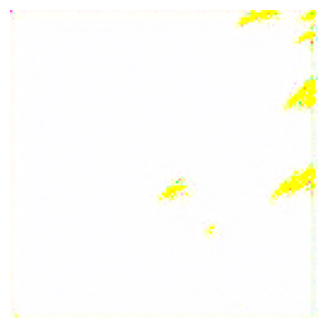

In [9]:
with torch.no_grad():
    images = model.sample_images(device=DEVICE)
    plt.figure(figsize=(4,4))
    plt.axis('off')
    for img in images:
        show_tensor_image(img.detach().cpu())
    plt.show()